# Sleep EMA Linear Mixed Models (LMM)

Replication Data for Wu et al. (2020) "Multi-Modal Data Collection for Measuring Health, Behavior, and Living Environment of Large-Scale Participant Cohorts: Conceptual Framework and Findings from Deployments": Ecological Momentary Assessment Data (Beiwe)

In [1]:
import pandas as pd
import numpy as np
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
from pymer4 import Lmer
from helpers import diagnostic_plots
from jmspack.utils import JmsColors

In [2]:
if "jms_style_sheet" in plt.style.available:
    plt.style.use("jms_style_sheet")

In [3]:
df = (pd.read_csv("data/UT1000_ema_wide.csv")
      .dropna()
      .assign(**{"date": lambda d: pd.to_datetime(d["survey.date"])})
      # .pipe(lambda d: d[d["survey.date"].str.contains("2019")])
      .drop("survey.date", axis=1)
      .pipe(lambda d: d[d["date"] <= pd.to_datetime("03-15-2019")])
      .pipe(lambda d: d[d["date"] >= pd.to_datetime("02-14-2019")])
      .sort_values(["pid", "date"])
      .reset_index(drop=True)
      )
display(df.head()); df.shape

,pid,content,energy,lonely,refreshed,restful,sad,sleep,stress,date
0,1193rv5x,3.0,3.0,2.0,2.0,3.0,1.0,5.0,1.0,2019-02-14
1,1193rv5x,2.0,3.0,3.0,1.0,2.0,2.0,6.0,1.0,2019-02-15
2,1193rv5x,1.0,2.0,3.0,1.0,2.0,2.0,9.0,1.0,2019-02-16
3,1193rv5x,1.0,1.0,3.0,2.0,2.0,3.0,9.0,2.0,2019-02-17
4,1193rv5x,3.0,3.0,1.0,1.0,2.0,1.0,5.0,1.0,2019-02-18


(4913, 10)

In [4]:
print(df.date.min()); print(df.date.max())

2019-02-14 00:00:00
2019-03-15 00:00:00


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4913 entries, 0 to 4912
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   pid        4913 non-null   object        
 1   content    4913 non-null   float64       
 2   energy     4913 non-null   float64       
 3   lonely     4913 non-null   float64       
 4   refreshed  4913 non-null   float64       
 5   restful    4913 non-null   float64       
 6   sad        4913 non-null   float64       
 7   sleep      4913 non-null   float64       
 8   stress     4913 non-null   float64       
 9   date       4913 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(8), object(1)
memory usage: 384.0+ KB


In [6]:
df.describe()

,content,energy,lonely,refreshed,restful,sad,sleep,stress
count,4913.000000,4913.000000,4913.000000,4913.000000,4913.000000,4913.000000,4913.000000,4913.000000
mean,1.871565,2.134948,0.513332,1.618563,1.834724,0.591696,6.237737,1.175453
std,0.823113,0.830693,0.731918,0.881945,0.858564,0.773247,1.687056,0.882876
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,2.000000,0.000000,1.000000,1.000000,0.000000,5.000000,1.000000
50%,2.000000,2.000000,0.000000,2.000000,2.000000,0.000000,6.000000,1.000000
75%,2.000000,3.000000,1.000000,2.000000,2.000000,1.000000,7.000000,2.000000
max,3.000000,4.000000,3.000000,3.000000,3.000000,3.000000,12.000000,3.000000


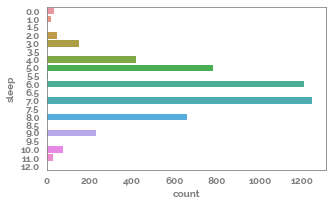

In [7]:
target="sleep"
group="pid"
checkpoint="date"
feature_list=df.select_dtypes(float).drop(target, axis=1).columns.tolist()
_ = plt.figure(figsize=(5,3))
_ = sns.countplot(y=df[target])

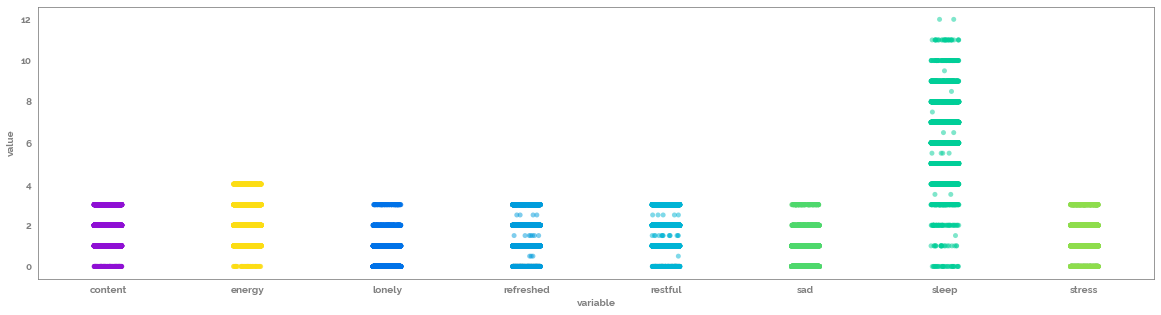

In [8]:
_ = plt.figure(figsize=(20, 5))
_ = sns.stripplot(data=df.select_dtypes(float).melt(), x="variable", y="value", alpha=0.5)

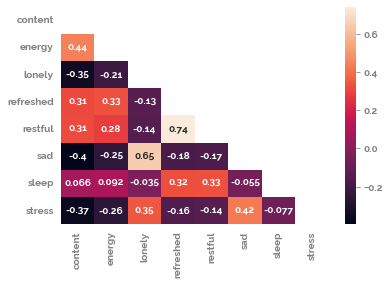

In [9]:
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
_ = sns.heatmap(df.corr(method="spearman"), mask=mask, annot=True)

In [10]:
cluster_collection = "+".join(feature_list)
cluster_collection

'content+energy+lonely+refreshed+restful+sad+stress'

In [11]:
formula_string = f"{target} ~ {cluster_collection} + (1 | {group}) + (1 | {checkpoint})"
model = Lmer(data=df, formula=formula_string)
initial_mod_fixed_eff = model.fit(no_warnings=True)
initial_mod_fixed_eff

Formula: sleep~content+energy+lonely+refreshed+restful+sad+stress+(1|pid)+(1|date)

Family: gaussian	 Inference: parametric

Number of observations: 4913	 Groups: {'pid': 411.0, 'date': 30.0}

Log-likelihood: -8756.933 	 AIC: 17513.866

Random effects:

                 Name    Var    Std
pid       (Intercept)  0.710  0.843
date      (Intercept)  0.046  0.214
Residual               1.780  1.334

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),4.929,4.690,5.169,0.122,1006.443,40.325,0.000,***
content,-0.064,-0.135,0.007,0.036,4733.664,-1.766,0.077,.
energy,0.025,-0.035,0.085,0.031,4876.512,0.826,0.409,
lonely,0.026,-0.059,0.110,0.043,4871.830,0.596,0.551,
refreshed,0.338,0.268,0.408,0.036,4755.562,9.434,0.000,***
restful,0.433,0.361,0.505,0.037,4766.650,11.838,0.000,***
sad,0.010,-0.070,0.090,0.041,4878.341,0.237,0.813,
stress,-0.040,-0.099,0.019,0.030,4885.360,-1.327,0.184,


In [12]:
cluster_collection="refreshed+restful"
formula_string = f"{target} ~ {cluster_collection} + (1 | {group}) + (1 | {checkpoint})"
model = Lmer(data=df, formula=formula_string)
fixed_eff = model.fit(no_warnings=True)
fixed_eff

Formula: sleep~refreshed+restful+(1|pid)+(1|date)

Family: gaussian	 Inference: parametric

Number of observations: 4913	 Groups: {'pid': 411.0, 'date': 30.0}

Log-likelihood: -8747.223 	 AIC: 17494.446

Random effects:

                 Name    Var    Std
pid       (Intercept)  0.714  0.845
date      (Intercept)  0.046  0.214
Residual               1.780  1.334

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),4.840,4.685,4.996,0.079,228.722,61.103,0.0,***
refreshed,0.339,0.270,0.409,0.035,4781.391,9.574,0.0,***
restful,0.429,0.357,0.500,0.036,4786.763,11.765,0.0,***


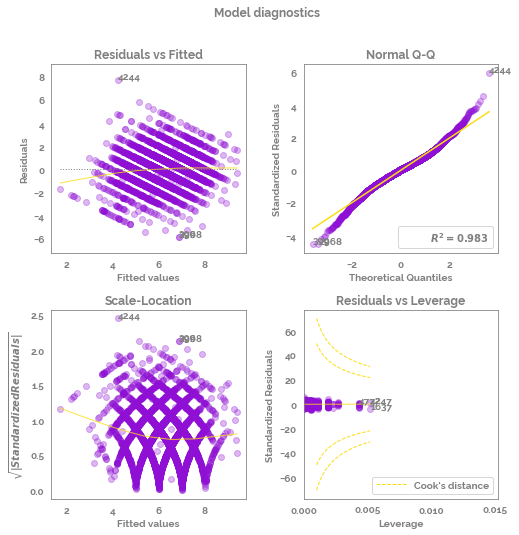

In [13]:
try:
    fig, axs = diagnostic_plots(model_fit=model,
                                         X=None,
                                         y=None,
                                         figsize = (8,8),
                                         limit_cooks_plot = False,
                                         subplot_adjust_args={"wspace": 0.3, "hspace": 0.3}
                                        )
except:
    print("The function did not run - this is likely due to multiple random effects being specified")

In [14]:
def r2_GLMM(model):
    sigma2_fe = model.design_matrix.multiply(model.fixef[0].mean()).var().sum()
    sigma2_re = model.ranef_var.loc[group, "Var"]
    sigma2_ol = model.ranef_var.loc["Residual", "Var"]
    r2_marginal = (sigma2_fe) / (sigma2_fe + sigma2_re + sigma2_ol)
    r2_conditional = (sigma2_fe + sigma2_re) / (sigma2_fe + sigma2_re + sigma2_ol)
    
    return pd.DataFrame({"Marginal_R_squared": r2_marginal,
                        "Conditional_R_squared": r2_conditional},
                       index=[0])

### Conditional and marginal R squared

- based on Nakagawa, S., & Schielzeth, H. (2013). A general and simple method for obtaining R2 from generalized linear mixed‐effects models. Methods in ecology and evolution, 4(2), 133-142.
- Marginal R-squared is the R-squared for just the fixed effects
- Conditional R-squared is the R-squared for both the fixed effects and random effects

In [15]:
r2_GLMM(model)

,Marginal_R_squared,Conditional_R_squared
0,0.082767,0.34553


In [16]:
predict_df = df.assign(**{f"{target}_fitted": model.fits})

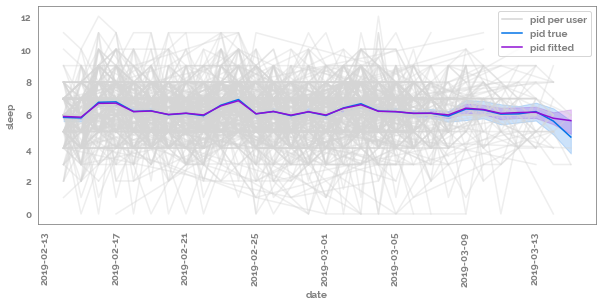

In [19]:
_ = plt.figure(figsize=(10, 4))
ax = sns.lineplot(data=predict_df,
                 x=checkpoint,
                 y=target,
                 hue=group, 
                 palette=list(np.repeat(JmsColors.OFFWHITE, repeats=predict_df[group].nunique())),
                 legend=False,
                 alpha=0.4)
_ = sns.lineplot(data=predict_df,
                 x=checkpoint,
                 y=target,
                 color=JmsColors.DARKBLUE,
                 ax=ax)
_ = sns.lineplot(data=predict_df,
                 x=checkpoint,
                 y=f"{target}_fitted",
                 color=JmsColors.PURPLE,
                 ax=ax)
_ = plt.xticks(rotation=90)
_ = plt.plot([], [], label=f"{group} per user", c=JmsColors.OFFWHITE)
_ = plt.plot([], [], label=f"{group} true", c=JmsColors.DARKBLUE)
_ = plt.plot([], [], label=f"{group} fitted", c=JmsColors.PURPLE)
_ = plt.legend()

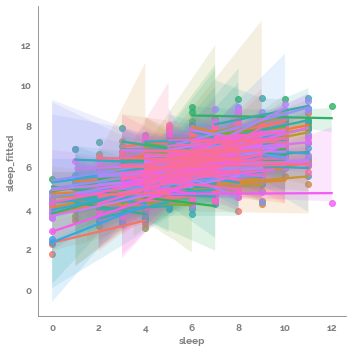

In [18]:
_ = sns.lmplot(data=predict_df, x=target, y=f"{target}_fitted", hue=group, legend=False)